### $5$-QUBIT CODE UNDER RANDOM PAULI ERROR

In this project, we create a function that takes as input $x \in \mathbb{F}_2^n$, and an error probability $p \in (0,1)$. The function quantum circuit that prepares the logical state, $\Ket{x_L}$, for the 5-qubit code, and runs it through a random Pauli error channel, with error rate $p$ (for each qubit), measures syndromes, applies the recovery operations, and measures the data qubits. We define the success probabilty to be the probabilty that a component of $\Ket{x_L}$ is measured at the end. We then visualize the dependence of the success probability for various values of p. 

In [37]:
%pip install qiskit qiskit_aer pylatexenc

Note: you may need to restart the kernel to use updated packages.


### The $5$-qubit code. 

The $5$-qubit code is a stabilizer code defined by the stabilizer group $\langle P_1, P_2, P_3, P_4 \rangle$, where $P_1=XZZX 1,P_2=1XZZX,P_3=X1XZZ,P_4=ZX1XZ$. 

In [38]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

### The syndrome measurement circuit. 

We design a circuit that gets the four syndromes for the $5$-qubit code, using measurement. 

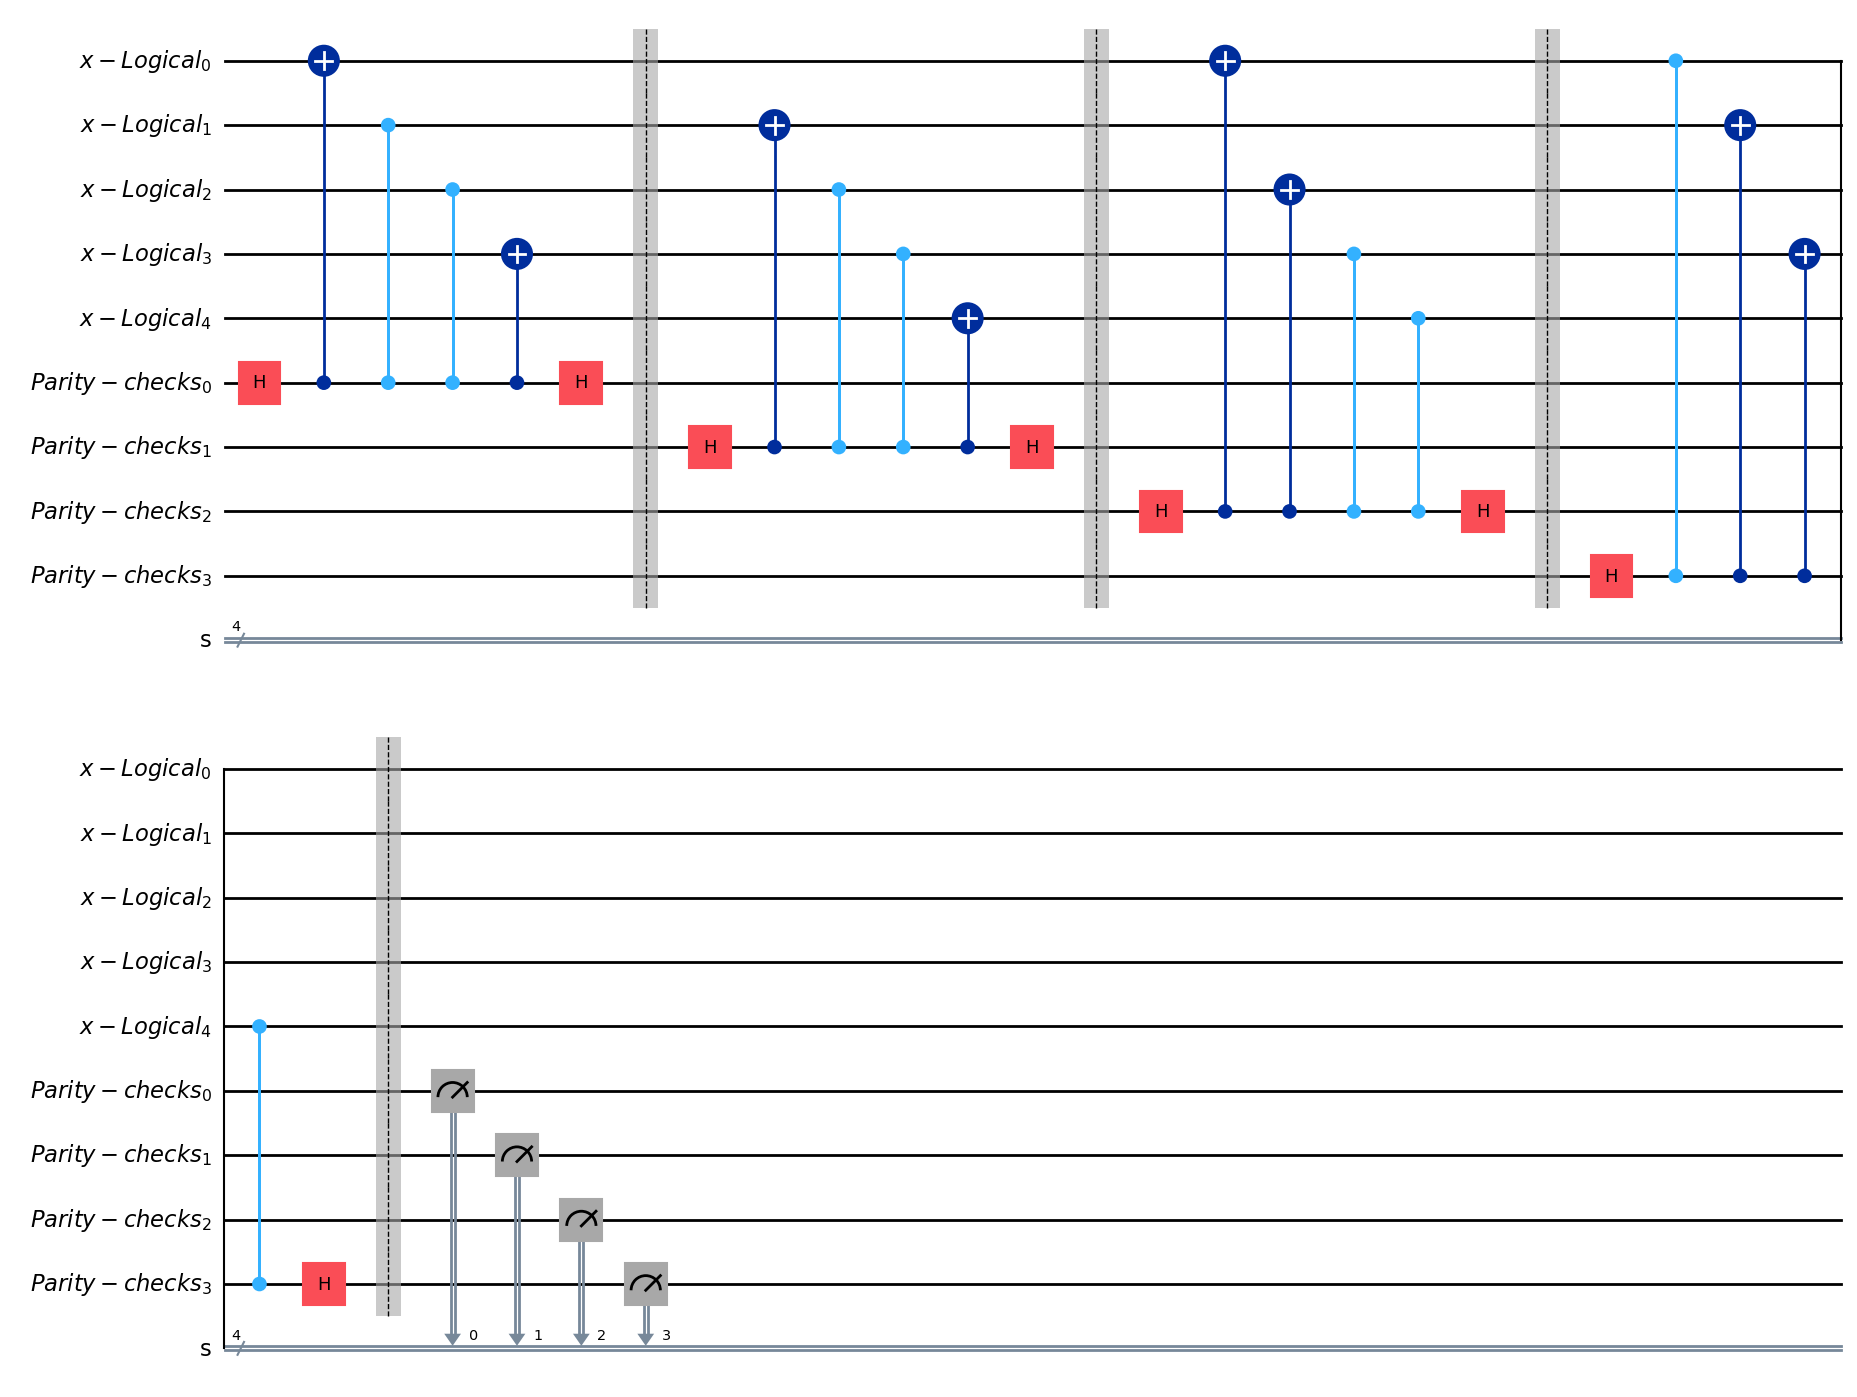

In [166]:
data_register=QuantumRegister(size=5, name="x-Logical")
check_register=QuantumRegister(size=4, name="Parity-checks")
code_circuit=QuantumCircuit(data_register, check_register)

# Extract syndrome for P_1=XZZX1
code_circuit.h(check_register[0])
code_circuit.cx(check_register[0],data_register[0])
code_circuit.cz(check_register[0], data_register[1])
code_circuit.cz(check_register[0], data_register[2])
code_circuit.cx(check_register[0], data_register[3])
code_circuit.h(check_register[0])
code_circuit.barrier()

# Extract syndrxome for P_2=1XZZX
code_circuit.h(check_register[1])
code_circuit.cx(check_register[1],data_register[1])
code_circuit.cz(check_register[1], data_register[2])
code_circuit.cz(check_register[1], data_register[3])
code_circuit.cx(check_register[1], data_register[4])
code_circuit.h(check_register[1])
code_circuit.barrier()

# Extract syndrome for P_3=X1XZZ
code_circuit.h(check_register[2])
code_circuit.cx(check_register[2],data_register[0])
code_circuit.cx(check_register[2], data_register[2])
code_circuit.cz(check_register[2], data_register[3])
code_circuit.cz(check_register[2], data_register[4])
code_circuit.h(check_register[2])
code_circuit.barrier()

# Extract syndrome for P_4=ZX1XZ
code_circuit.h(check_register[3])
code_circuit.cz(check_register[3],data_register[0])
code_circuit.cx(check_register[3], data_register[1])
code_circuit.cx(check_register[3], data_register[3])
code_circuit.cz(check_register[3], data_register[4])
code_circuit.h(check_register[3])
code_circuit.barrier()

#Measure syndromes
syndromes = ClassicalRegister(size=4, name="s")
code_circuit.add_register(syndromes)
# measure
code_circuit.measure(check_register, syndromes)
code_circuit.draw(output="mpl")

### fixing errors

We now add fixes to the circuit depending on what the measuements are. The following are the syndromes for each possible single qubit error. 

| **syndrome (as number)** | **Syndrome, as string (0,1,2,3)** | **Error**|
|------------------------|---------------|----------|
| 1                   | 1000          |  X[1]       |
| 2                   | 0100          |  Z[4]       |
| 3                   | 1010          |  5      |
| 4                   | 0100          |  2       |
| 5                   | 0110          |  6       |
| 6                   | 1100          |  3      |
| 7                   | 1000          |  1       |
| 8                   | 0001          |  8       |
| 9                   | 0011          |  12       |
| 10                   | 1111          |  15      |
| 11                   | 1110          |  7      |
| 12                   | 1101          |  11      |
| 13                   | 1011          |  13      |
| 14                   | 0111          |  14       |
| 15                   | 1001          |  9       |




In [211]:

with code_circuit.if_test((syndromes,1)):
    code_circuit.x(data_register[1])
with code_circuit.if_test((syndromes,2)):
    code_circuit.z(data_register[4])
with code_circuit.if_test((syndromes,3)):
    code_circuit.x(data_register[2])
with code_circuit.if_test((syndromes,4)):
    code_circuit.z(data_register[2])
with code_circuit.if_test((syndromes,5)):
    code_circuit.z(data_register[0])
with code_circuit.if_test((syndromes,6)):
    code_circuit.x(data_register[3])
with code_circuit.if_test((syndromes,7)):
    code_circuit.y(data_register[2])
with code_circuit.if_test((syndromes,8)):
    code_circuit.x(data_register[0])
with code_circuit.if_test((syndromes,9)):
    code_circuit.z(data_register[3])
with code_circuit.if_test((syndromes,10)):
    code_circuit.z(data_register[1])
with code_circuit.if_test((syndromes,11)):
    code_circuit.y(data_register[1])
with code_circuit.if_test((syndromes,12)):
    code_circuit.x(data_register[4])
with code_circuit.if_test((syndromes,13)):
    code_circuit.y(data_register[0])
with code_circuit.if_test((syndromes,14)):
    code_circuit.y(data_register[4])
with code_circuit.if_test((syndromes,15)):
    code_circuit.y(data_register[3])

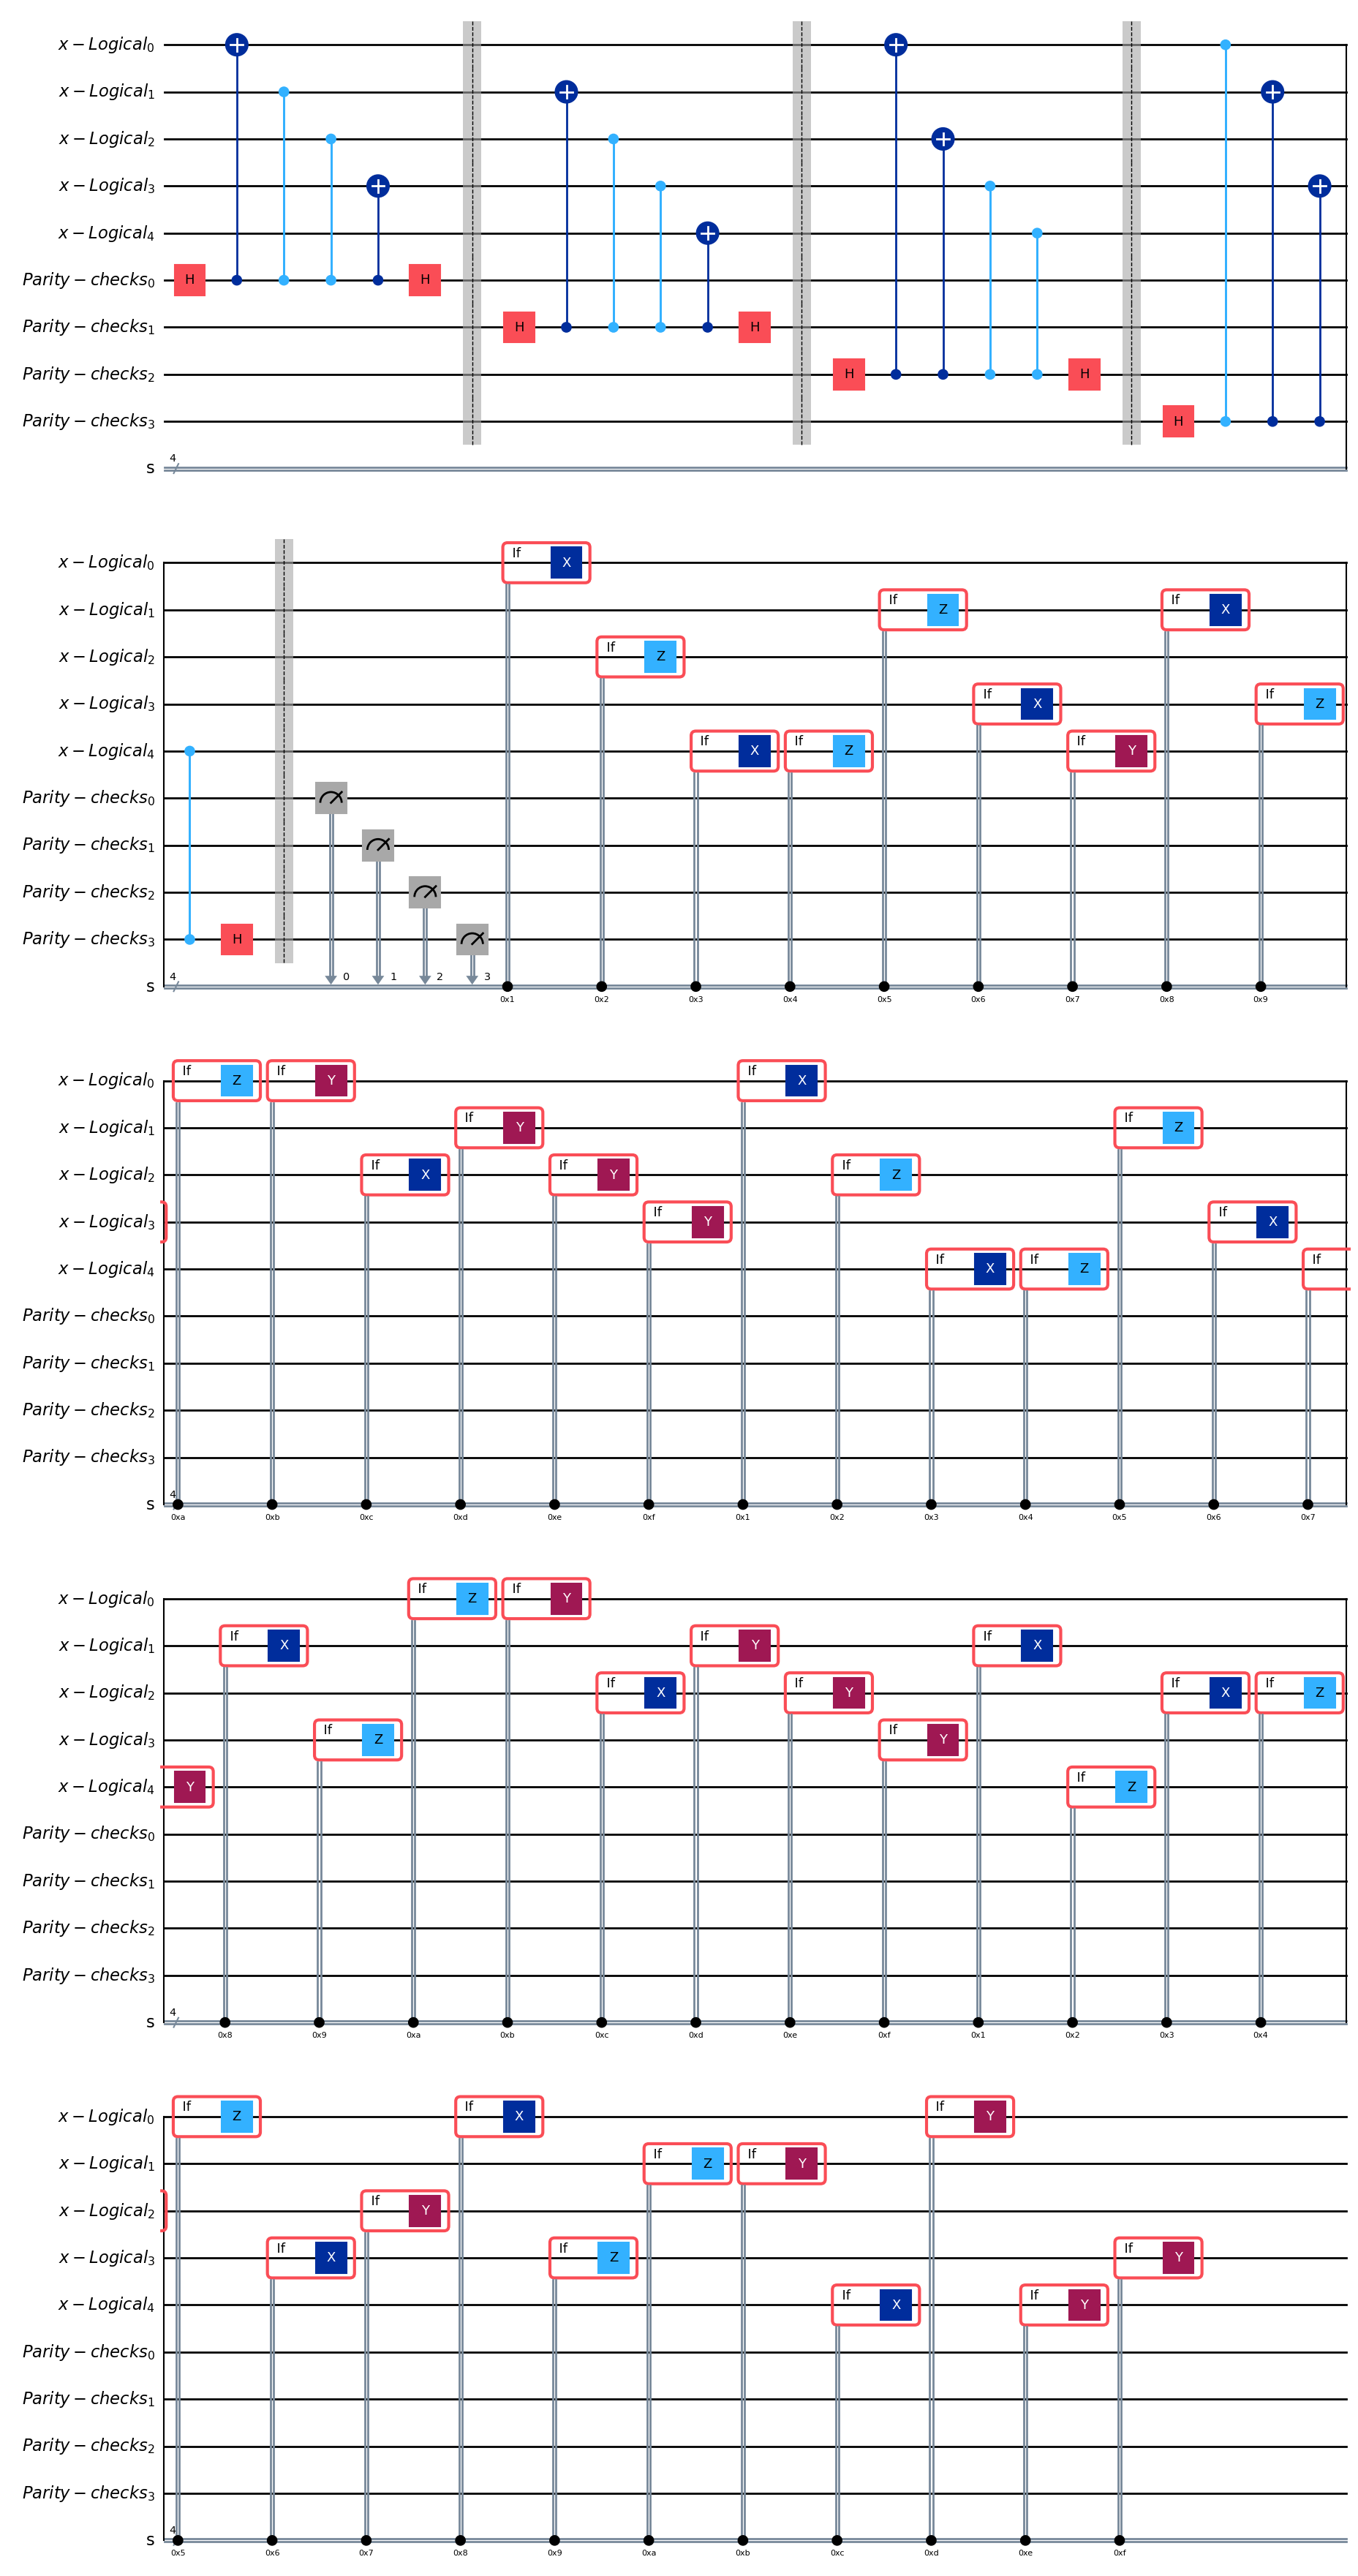

In [212]:
code_circuit.draw(output="mpl")

### The state preparation circuit

We need to implement a circuit that prepares 

$$
\Ket{0_L} = \frac{1}{4} \Big(
\Ket{00000} + \Ket{10010} + \Ket{01001} + \Ket{10100} + \Ket{01010} 
- \Ket{11011} - \Ket{00110} - \Ket{11000} \\
- \Ket{11101} - \Ket{00011} - \Ket{11110} - \Ket{01111} 
- \Ket{10001} - \Ket{01100} - \Ket{10111} + \Ket{00101}
\Big)
$$

$$
\Ket{1_L} = \frac{1}{4} \Big(
\Ket{11111} + \Ket{01101} + \Ket{10110} + \Ket{01011} + \Ket{10101} 
- \Ket{00100} - \Ket{11001} - \Ket{00111} \\
- \Ket{00010} - \Ket{11100} - \Ket{00001} - \Ket{10000} 
- \Ket{01110} - \Ket{10011} - \Ket{01000} + \Ket{11010}
\Big)
$$


In [228]:
from qiskit.quantum_info import Statevector

# Define basis states as numbers

bitstrings = [
    '00000', '01001', '10010', '00101', '01010',
    '11011', '01100', '00011', '10111', '11000',
    '01111', '11110', '10001', '00110', '11101', '10100'
]

# Define coefficients (signs)
signs = [1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]

# Create statevector
N = 5
dim = 2 ** N
vec = np.zeros(dim, dtype=complex)

for bstring, sign in zip(bitstrings, signs):
    idx = int(bstring, 2)
    vec[idx] = sign

# Normalize
vec /= 4

logical_ket0_vector = [
        1 / 4,
        0,
        0,
        1 / 4,
        0,
        -(1 / 4),
        1 / 4,
        0,
        0,
        -(1 / 4),
        -(1 / 4),
        0,
        1 / 4,
        0,
        0,
        -(1 / 4),
        0,
        1 / 4,
        -(1 / 4),
        0,
        -(1 / 4),
        0,
        0,
        -(1 / 4),
        1 / 4,
        0,
        0,
        -(1 / 4),
        0,
        -(1 / 4),
        -(1 / 4),
        0,
    ]

# Make a Qiskit statevector object
logical_zero = Statevector(vec)

print(logical_zero)


Statevector([ 0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j,
              0.25+0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,
              0.25+0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j,
             -0.25+0.j,  0.  +0.j, -0.25+0.j,  0.25+0.j,  0.  +0.j,
              0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j, -0.25+0.j,
              0.  +0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j, -0.25+0.j,
             -0.25+0.j,  0.  +0.j],
            dims=(2, 2, 2, 2, 2))


In [229]:
logical_zero.draw("Latex", max_size=120)

<IPython.core.display.Latex object>

In [230]:
## Check syndrome on X[0] error. 



### Running Logical zero through a random pauli channel with error p

In [231]:
def pauli_error(p):
    ## input :p
    ## output: the logical 0 state after passing through the pauli channel with error p (each register flips with probability p)
    data_register=QuantumRegister(size=5, name="x-Logical")
    circuit=QuantumCircuit(data_register)
    for i in range(5):
        rand_float=np.random.rand()
        if rand_float < p/3:
            circuit.x([i])
        elif rand_float < 2*p/3:
            circuit.y([i])
        elif rand_float < p:
            circuit.z([i])
    return circuit

### Putting it all together!

We create a correction circuit that first adds pauli errors to a state and then corrects them. 

In [250]:
def correction_circuit(p):
    data_register=QuantumRegister(size=5, name="x-Logical")
    check_register=QuantumRegister(size=4, name="Parity-checks")
    syndromes = ClassicalRegister(size=4, name="s")
    circuit=QuantumCircuit(data_register, check_register, syndromes)
    ## Add the logical 0 state at the front
    logical_qubits = [0, 1, 2, 3, 4]

    # Insert initialization at the front
    circuit.initialize(logical_zero.data, logical_qubits)

    
    ## Attach pauli error circuit
    #circuit.compose(pauli_error(p), qubits=data_register, inplace=True)
    circuit.z(0)
    ## attach error correction circuit
    circuit.compose(code_circuit, inplace=True)
    ## Measure the data qubits
    output = ClassicalRegister(size=5, name="measurement")
    circuit.add_register(output)
    circuit.barrier()
    circuit.measure(data_register, output)
    return circuit

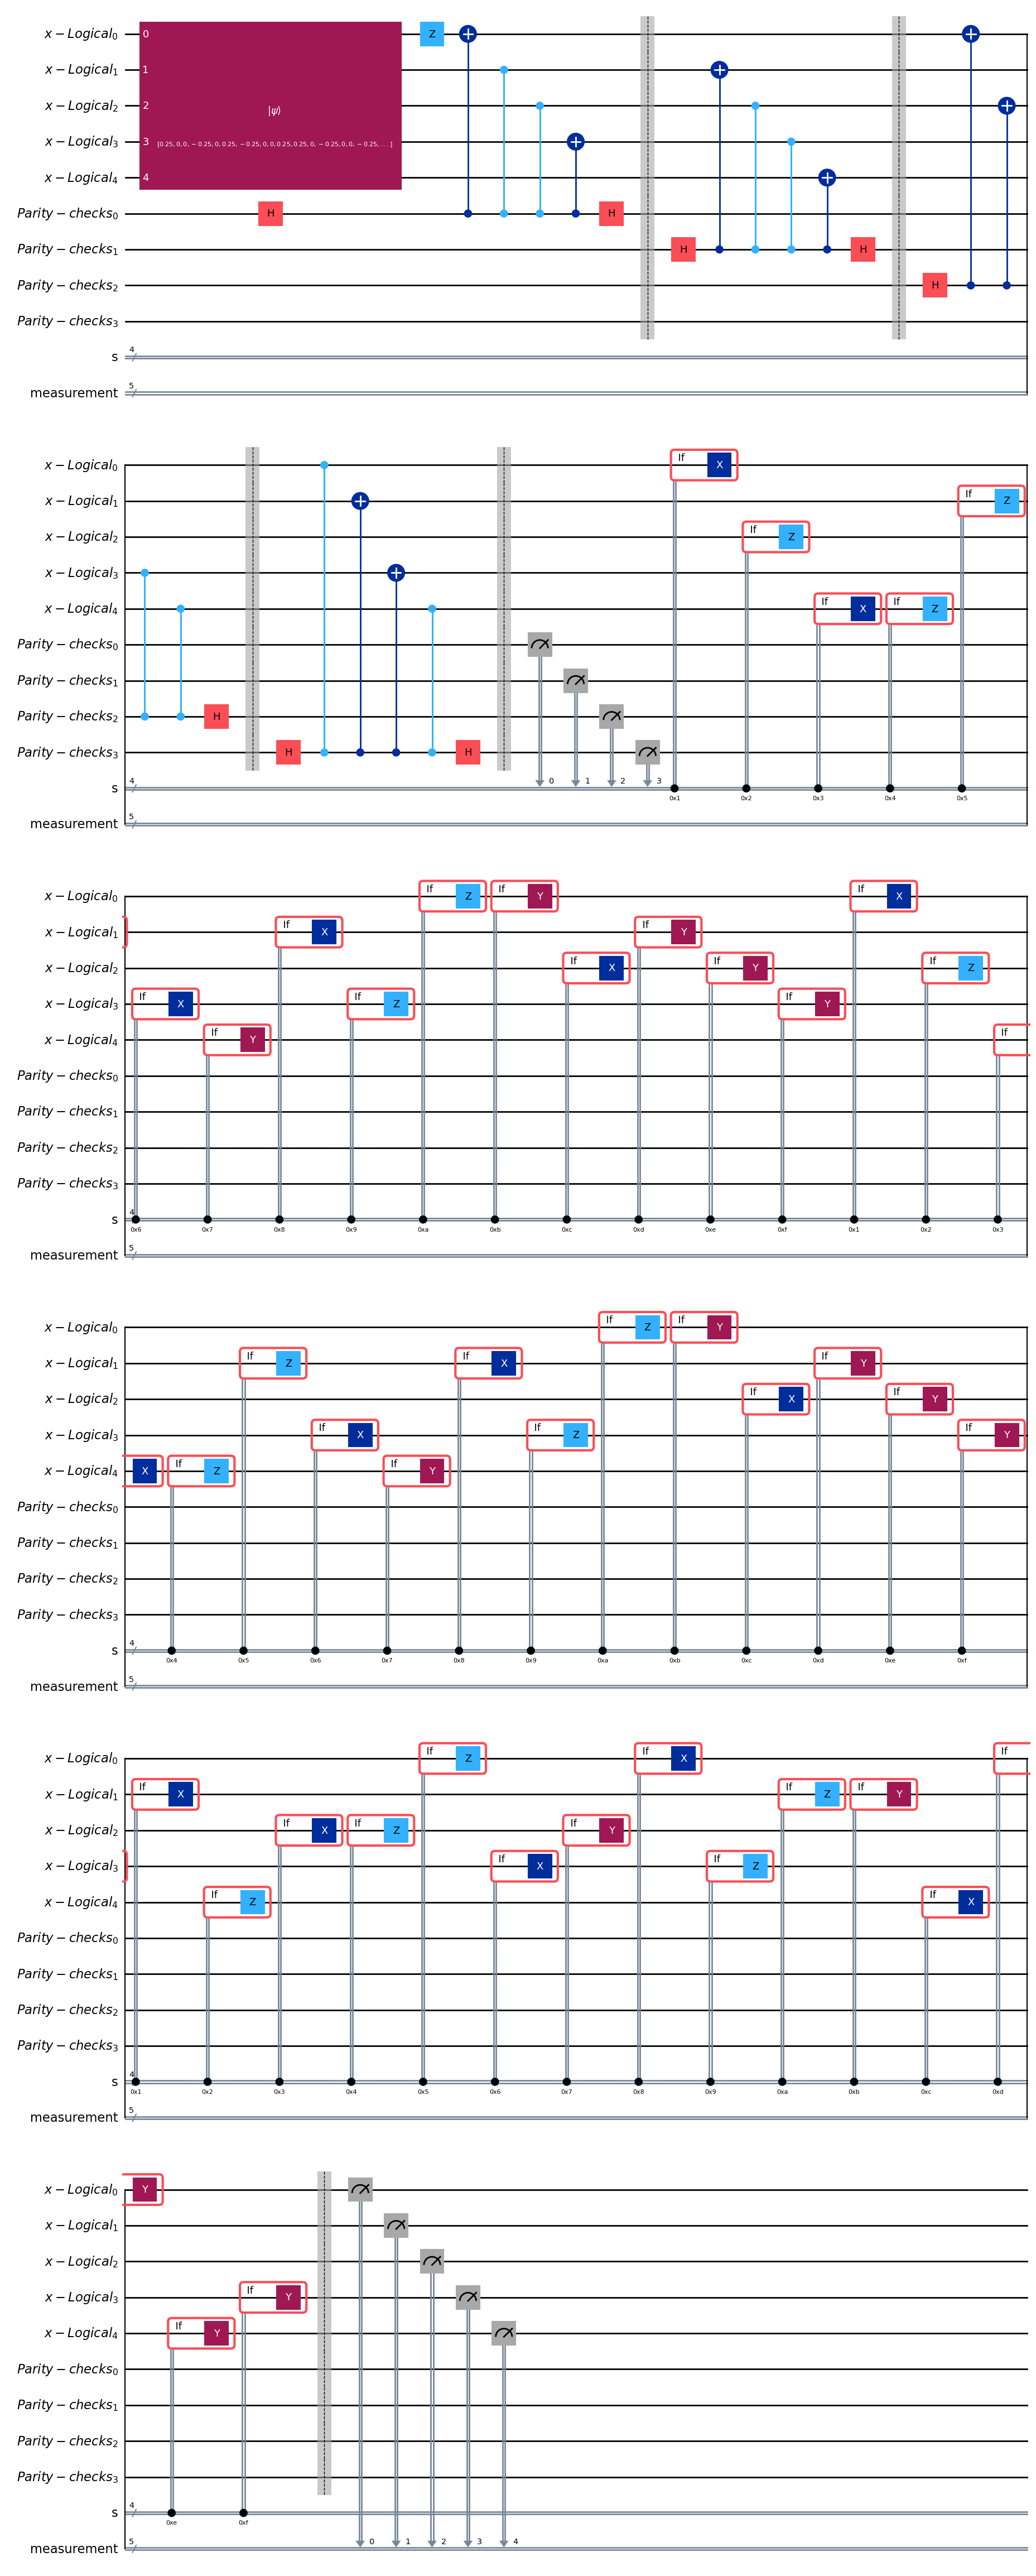

In [251]:
correction_circuit(0.1).draw(output="mpl")

### Final part: testing!

We run the circuit on the Logical $0$ we have earlier prepared and output true if the final state is same as the logical 0 state. 

In [252]:
## test ability to correct x[0] error. 
qec_circuit = correction_circuit(p)
simulator = AerSimulator()
shots = 10
compiled_circuit = transpile(qec_circuit, simulator)
job = simulator.run(compiled_circuit, shots=10)

result=job.result()
counts=result.get_counts()

In [253]:
counts

{'01001 0101': 1,
 '10001 0101': 1,
 '10100 0101': 1,
 '11011 0101': 1,
 '10111 0101': 1,
 '00000 0101': 4,
 '01111 0101': 1}

In [243]:
# --- Logical zero basis states ---
logical_zero_amplitudes = logical_zero.data
num_qubits = logical_zero.num_qubits

supported_states = []
for idx, amp in enumerate(logical_zero_amplitudes):
    if not np.isclose(amp, 0):
        supported_states.append(idx)

print("Basis states in logical zero state:", supported_states)

Basis states in logical zero state: [0, 3, 5, 6, 9, 10, 12, 15, 17, 18, 20, 23, 24, 27, 29, 30]


In [238]:
# --- Safe parse ---
logical_zero_counts = 0
for key, freq in counts.items():
    parts = key.split()
    if len(parts) == 2:
        logical_bits, syndrome_bits = parts
    else:
        logical_bits = parts[1]
    if logical_bits in supported_bitstrings:
        logical_zero_counts += freq

prob_logical_zero_component = logical_zero_counts / shots

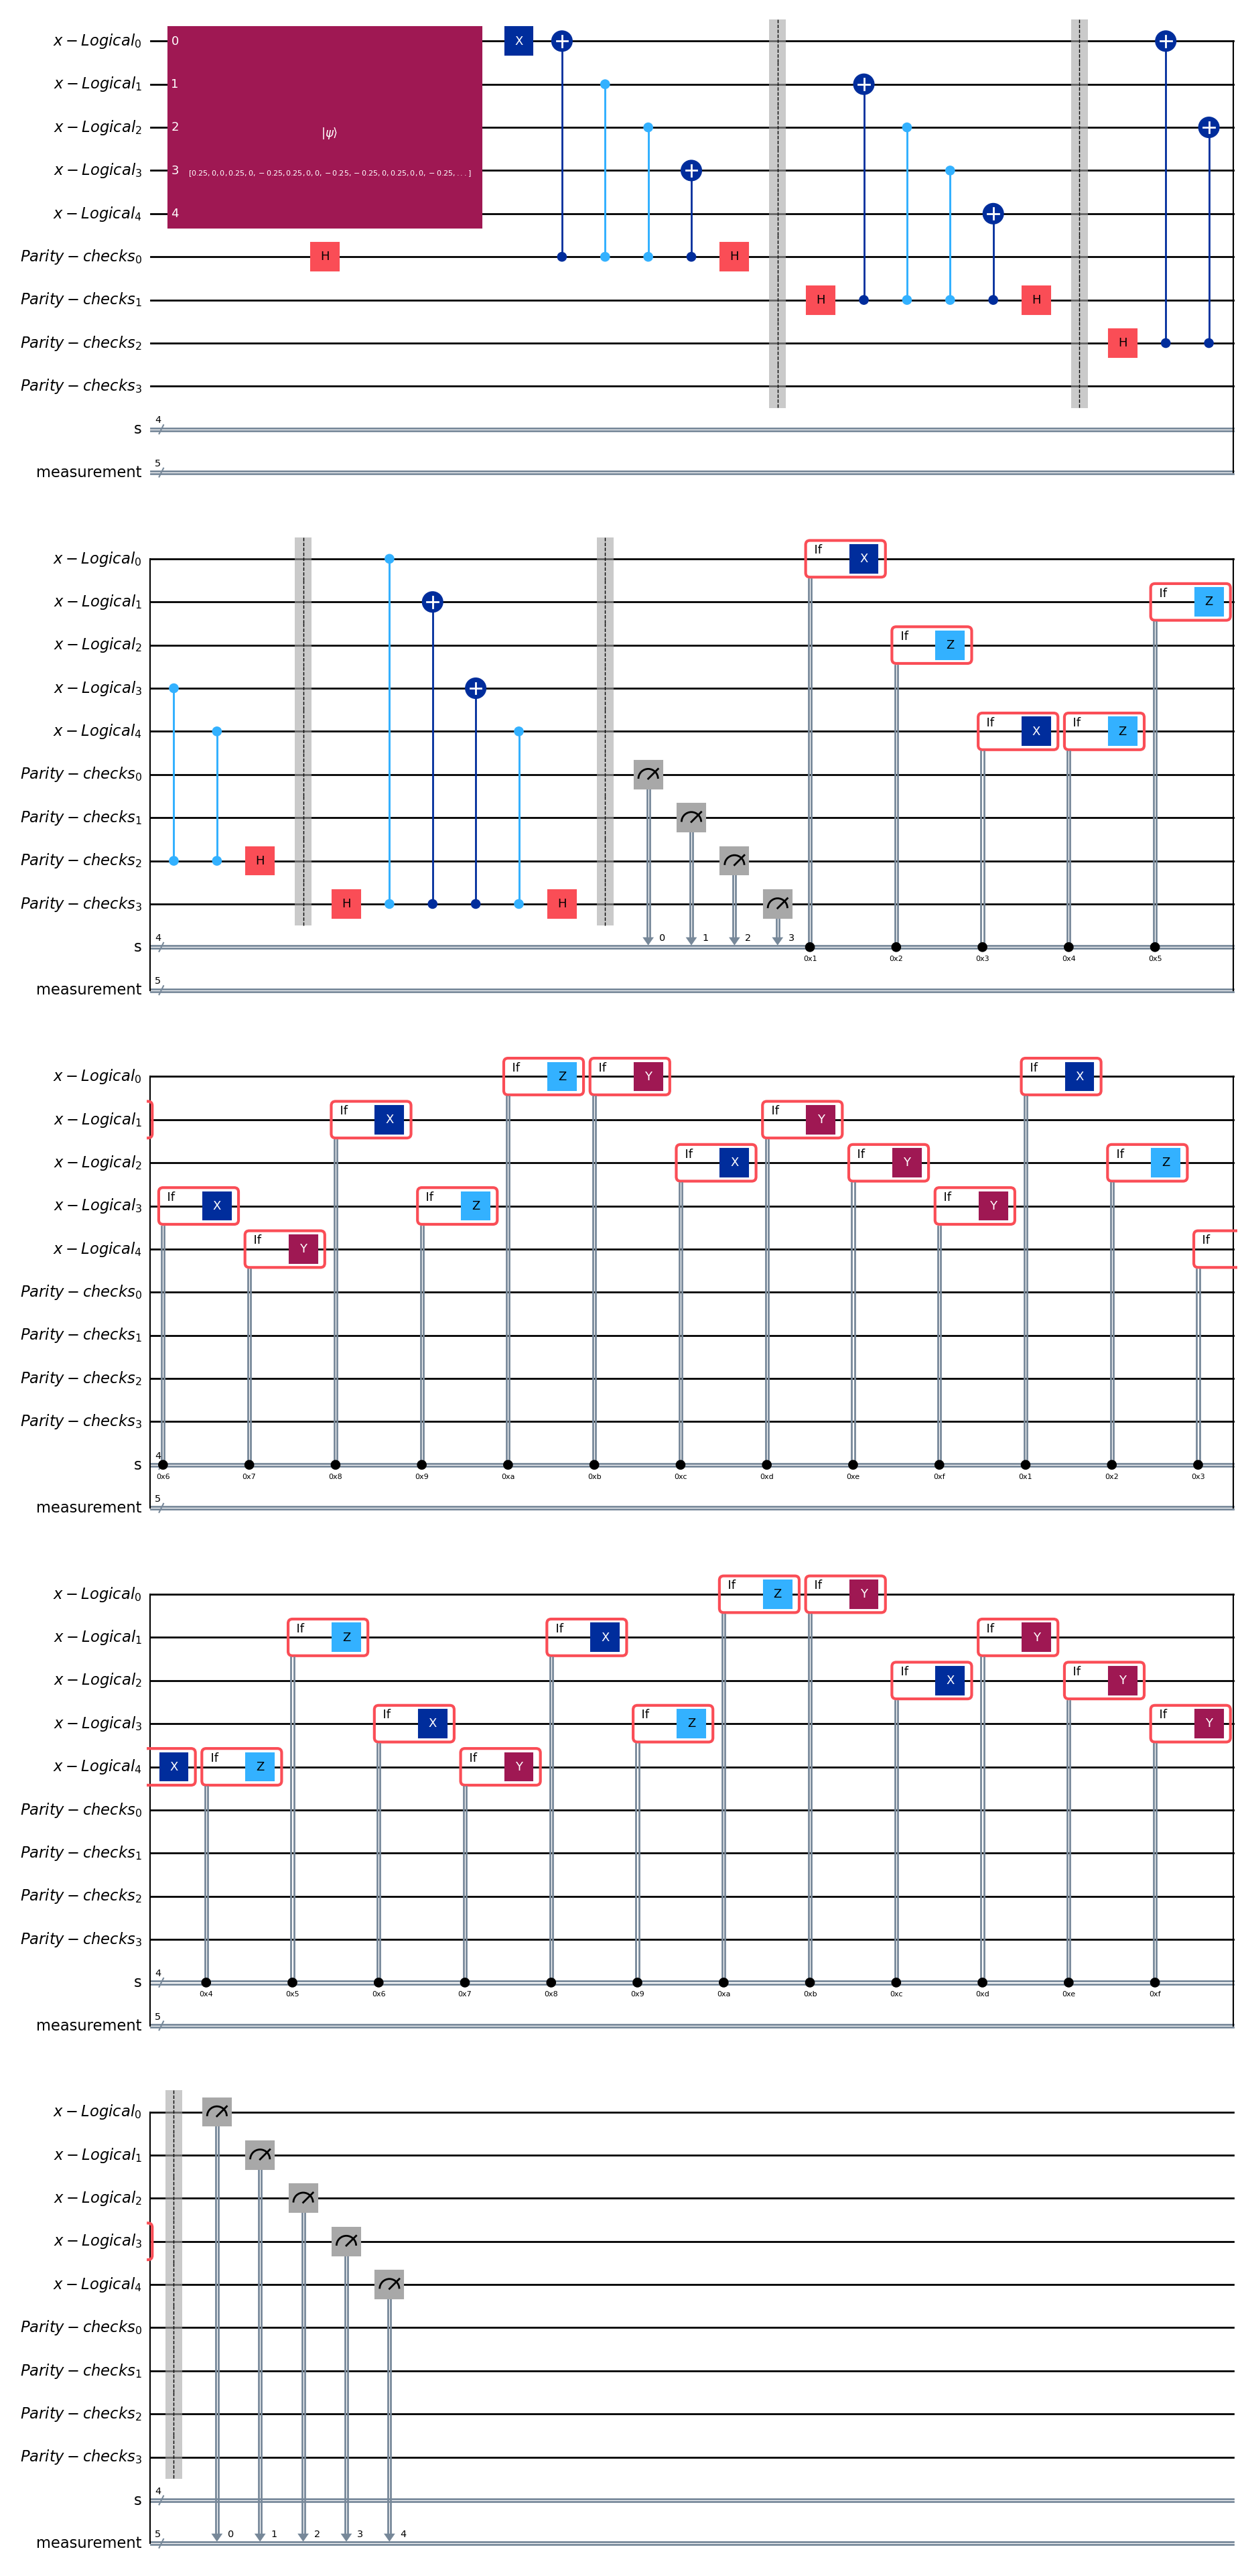

In [199]:
qec_circuit.draw(output="mpl")

In [249]:

from qiskit_aer import AerSimulator
import numpy as np

p = 0.9
qec_circuit = correction_circuit(p)

# --- Logical zero basis states ---
logical_zero_amplitudes = logical_zero.data
num_qubits = logical_zero.num_qubits

supported_bitstrings = []
for idx, amp in enumerate(logical_zero_amplitudes):
    if not np.isclose(amp, 0):
        bitstring = format(idx, f'0{num_qubits}b')[::-1]
        supported_bitstrings.append(bitstring)

print("Basis states in logical zero state:", supported_bitstrings)

# --- Run ---
simulator = AerSimulator()
shots = 200
compiled_circuit = transpile(qec_circuit, simulator)
job = simulator.run(compiled_circuit, shots=shots)  
result = job.result()
counts = result.get_counts()

# --- Safe parse ---
logical_zero_counts = 0
for key, freq in counts.items():
    parts = key.split()
    if len(parts) == 2:
        logical_bits, syndrome_bits = parts
    else:
        logical_bits = parts[1]
    if logical_bits in supported_bitstrings:
        logical_zero_counts += freq

prob_logical_zero_component = logical_zero_counts / shots

print(f"Probability of measuring a basis state supported by logical |0>: {prob_logical_zero_component:.6f}")


Basis states in logical zero state: ['00000', '11000', '10100', '01100', '10010', '01010', '00110', '11110', '10001', '01001', '00101', '11101', '00011', '11011', '10111', '01111']
Probability of measuring a basis state supported by logical |0>: 1.000000


### We document the results for different values of $p$:


| **p** | **Probabilisty of successful decoding** |
|---------------------|----------|
| 0                   | 1        |  
| 0.1                 |0010      | 
 


In [185]:
counts

{'10010 1111': 1,
 '00011 1011': 1,
 '11010 0010': 1,
 '10001 0001': 1,
 '01110 1010': 2,
 '00100 1001': 1,
 '00110 1000': 1,
 '10100 1000': 1,
 '01101 0100': 1,
 '00110 0011': 1,
 '00010 1010': 1,
 '01100 0001': 1,
 '01111 0110': 1,
 '01111 1101': 2,
 '00001 0000': 1,
 '00000 0110': 2,
 '00001 0010': 1,
 '10010 1011': 1,
 '11110 0011': 1,
 '00100 0100': 1,
 '01100 1100': 1,
 '00110 1101': 1,
 '11000 1000': 1,
 '01111 1110': 1,
 '01101 0000': 1,
 '01001 1011': 1,
 '01100 1011': 2,
 '11000 1100': 1,
 '00110 1100': 1,
 '11101 1000': 1,
 '00000 1101': 2,
 '11010 0100': 1,
 '10001 1110': 2,
 '00000 0111': 1,
 '00100 0101': 2,
 '00011 1101': 2,
 '11000 1110': 3,
 '11111 0010': 2,
 '10101 1001': 3,
 '11000 1101': 2,
 '00010 0100': 2,
 '10010 0011': 1,
 '00001 0101': 2,
 '10000 0010': 1,
 '00001 0100': 1,
 '11000 0011': 2,
 '01010 1101': 1,
 '10100 0111': 1,
 '10010 1000': 2,
 '00101 0011': 1,
 '11101 1101': 1,
 '01111 0001': 1,
 '10111 1011': 2,
 '01000 1010': 2,
 '11111 1001': 1,
 '01001 01